<a href="https://colab.research.google.com/github/gks4478/section2_project/blob/main/section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('mussorie_reviews.csv')

In [ ]:
df.head()

,Review,Date of stay,Rating
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,"<span class=""ui_bubble_rating bubble_50""></span>"
1,NaN,NaN,NaN
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,"<span class=""ui_bubble_rating bubble_50""></span>"
3,NaN,NaN,NaN
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,"<span class=""ui_bubble_rating bubble_50""></span>"


In [ ]:
import re
from nltk.corpus import stopwords as StopWords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# 1. 결측치 삭제
df.dropna(inplace= True)
# 2. 중복치 삭제
df.drop_duplicates(inplace= True)
# 3. Rating 평점 생성
df["Rating"] = df["Rating"].apply(lambda x: re.findall("\d", x)[0])
# 4. Sentiment 생성
df['Sentiment'] = df['Rating'].map({"5":"Positive", "4":"Positive", "3":"Neutral", "2":"Negative", "1":"Negative"})
# 5. year 생성
df['year'] = df['Date of stay'].apply(lambda x: int(x.split()[-1]))
# 6. month 생성
df['month'] = df['Date of stay'].apply(lambda x: x.split()[-2])
# 7. 3점 삭제
df.drop(df[df['Sentiment'] == 'Neutral'].index, axis = 0, inplace = True)
# 8. 2017년 이하 삭제
df.drop(df[df["year"] < 2018].index, axis=0, inplace=True)
# 9. 필요없는 특성 삭제
df.drop('Date of stay', axis = 1, inplace=True)
# 10. 인덱스 리셋
df.reset_index(inplace= True, drop= True)

In [ ]:
df.head()

,Review,Rating,Sentiment,year,month
0,Most beautiful stay at Mussoorie...such a gorg...,5,Positive,2021,August
1,The Savoy is one of those rare hotels that not...,5,Positive,2020,October
2,Def Best stay in Uttarakand ! Amazing nature. ...,5,Positive,2021,November
3,Very very friendly and efficient staff … loved...,5,Positive,2021,November
4,Exceptional property. Just great experience. V...,5,Positive,2021,October


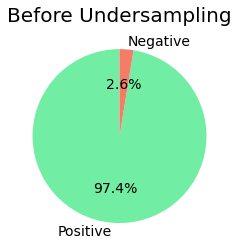

In [ ]:
# target 분포
s = df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, fontsize=14, colors=['#72EEA4', '#F37D67']);
s.set_ylabel('');
s.set_title('Before Undersampling', fontsize=20);

In [ ]:
# 11. 리뷰 전처리 함수 생성
def preprocess_data(text):
    
    text = re.sub(r'[0-9]+', '', str(text))   # 숫자 삭제
    text = re.sub(r'[^\w\s]', '', str(text))   # 구두점 삭제
    text = " ".join(x.lower() for x in text.split())  # 소문자로 변환
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # urls 삭제
    text = re.sub(r'<.*?>', '', text) # html 삭제
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # 이모지 삭제
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(x for x in text.split() if x not in StopWords.words('english'))
    return text

In [ ]:
# 12. Preprocessed_reviews 새로 생성(리뷰 전처리 함수 이용)
df["Preprocessed_reviews"] = df["Review"].apply(lambda x: preprocess_data(x))

In [ ]:
# 13. Reviews의 전체를 문자열 하나로 저장
all_text = " ".join(list(df["Preprocessed_reviews"]))

In [ ]:
# 14. all_text를 공백으로 나누고 시리즈 형태로 저장(이러면 빈도수 카운트하기 좋음)
words = pd.Series(all_text.split(" "))

In [ ]:
# 15. words에서 가장 많은 단어 상위 20개 고른다.(그거 뭐지 그 많은거 삭제하는 그거 그걸 위한것)
frequent_words = words.value_counts()[:20]

In [ ]:
# 16. Preprocessed_reviews에 frequent_words 중 하나라도 포함되어 있으면 삭제하고 문자열 하나로 만든다.
df["Preprocessed_reviews"] = df["Preprocessed_reviews"].apply(lambda x: " ".join([word for word in str(x).split() if word not in frequent_words]))

In [ ]:
# 17. Sentiment 인코더(1: pos, 0: neg)
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])

In [ ]:
# 18. train, test, val 나누기
xtrain, xtest, ytrain, ytest = train_test_split(df['Review'], df['Sentiment'], 
                                                  stratify=df['Sentiment'], 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, 
                                                  stratify=ytrain, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [ ]:
# 19. TF-IDF 으로 벡터로 바꿈
tfv = TfidfVectorizer(min_df=3,  max_features=None, decode_error = "replace", preprocessor = preprocess_data,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(list(xtrain))

xtrain_tfv = tfv.transform(xtrain)
xval_tfv = tfv.transform(xval)

In [ ]:
# 20. RandomUndersampling
Xtrain_samp, ytrain_samp = RandomUnderSampler(random_state=42).fit_resample(xtrain_tfv, ytrain)

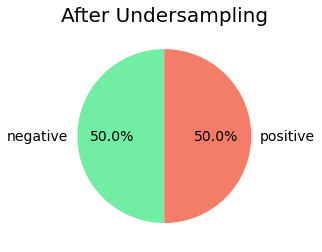

In [ ]:
# 타겟 분포
s = ytrain_samp.replace({1:'positive', 0:'negative'}).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, fontsize=14, colors=['#72EEA4', '#F37D67'])
# s = ytrain_samp.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, fontsize=14, colors=['#72EEA4', '#F37D67']);
s.set_ylabel('');
s.set_title('After Undersampling', fontsize=20);

In [ ]:
# 22. xgb 모델
xgb = XGBClassifier()
xgb.fit(Xtrain_samp, ytrain_samp)

ypred_xg = xgb.predict(xval_tfv)
print(classification_report(yval, ypred_xg))
print("accuracy:", accuracy_score(yval , ypred_xg).round(3))

predictions = xgb.predict_proba(xval_tfv)
print("logloss: %0.3f " % log_loss(yval, predictions))

              precision    recall  f1-score   support

           0       0.13      0.82      0.23        17
           1       0.99      0.86      0.92       647

    accuracy                           0.86       664
   macro avg       0.56      0.84      0.57       664
weighted avg       0.97      0.86      0.90       664

accuracy: 0.857
logloss: 0.338 


In [ ]:
# 23. MNB 모델
MNB = MultinomialNB()
MNB.fit(Xtrain_samp, ytrain_samp)

ypred_xg = MNB.predict(xval_tfv)
print(classification_report(yval, ypred_xg))
print("accuracy:", accuracy_score(yval , ypred_xg).round(3))

predictions = MNB.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

              precision    recall  f1-score   support

           0       0.18      1.00      0.31        17
           1       1.00      0.88      0.94       647

    accuracy                           0.88       664
   macro avg       0.59      0.94      0.62       664
weighted avg       0.98      0.88      0.92       664

accuracy: 0.884
logloss: 0.479 


In [ ]:
# 24. svc 모델
svc = SVC(kernel='linear', probability=True)
svc.fit(Xtrain_samp, ytrain_samp)

ypred_xg = svc.predict(xval_tfv)
print(classification_report(yval, ypred_xg))
print("accuracy:", accuracy_score(yval , ypred_xg).round(3))

predictions = svc.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))


              precision    recall  f1-score   support

           0       0.43      0.94      0.59        17
           1       1.00      0.97      0.98       647

    accuracy                           0.97       664
   macro avg       0.72      0.95      0.79       664
weighted avg       0.98      0.97      0.97       664

accuracy: 0.967
logloss: 0.123 


In [ ]:
# 25. decision tree 모델
dec_tree = DecisionTreeClassifier()
dec_tree.fit(Xtrain_samp, ytrain_samp)

ypred_xg = dec_tree.predict(xval_tfv)
print(classification_report(yval, ypred_xg))
print("accuracy:", accuracy_score(yval , ypred_xg).round(3))

predictions = dec_tree.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

              precision    recall  f1-score   support

           0       0.10      0.88      0.18        17
           1       1.00      0.79      0.88       647

    accuracy                           0.79       664
   macro avg       0.55      0.83      0.53       664
weighted avg       0.97      0.79      0.86       664

accuracy: 0.788
logloss: 7.334 


In [ ]:
# 26. logistic regression 모델
log_reg = LogisticRegression()
log_reg.fit(Xtrain_samp,ytrain_samp)

ypred_xg = log_reg.predict(xval_tfv)
print(classification_report(yval, ypred_xg))
print("accuracy:", accuracy_score(yval , ypred_xg).round(3))

predictions = log_reg.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

              precision    recall  f1-score   support

           0       0.44      0.94      0.60        17
           1       1.00      0.97      0.98       647

    accuracy                           0.97       664
   macro avg       0.72      0.96      0.79       664
weighted avg       0.98      0.97      0.97       664

accuracy: 0.968
logloss: 0.481 


In [ ]:
# 27. SGDC 모델
SGDC = SGDClassifier(loss= 'log')
SGDC.fit(Xtrain_samp, ytrain_samp)

ypred_xg = SGDC.predict(xval_tfv)
print(classification_report(yval, ypred_xg))
print("accuracy:", accuracy_score(yval , ypred_xg).round(3))

predictions = SGDC.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

              precision    recall  f1-score   support

           0       0.38      0.94      0.54        17
           1       1.00      0.96      0.98       647

    accuracy                           0.96       664
   macro avg       0.69      0.95      0.76       664
weighted avg       0.98      0.96      0.97       664

accuracy: 0.959
logloss: 0.212 


In [ ]:
# 28. 모델 튜닝 학습
from sklearn.model_selection import GridSearchCV
params = {'C': [1,4,8,16,32], 'kernel' : ['linear','rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc,params, cv = 5)
svc_grid.fit(Xtrain_samp,ytrain_samp)

In [ ]:
# 28. 최종 모델 학습 : svc 모델
xtest_tfv = tfv.transform(xtest) # TF-IDF

ypred_xg = svc_grid.predict(xtest_tfv)
print(classification_report(ytest, ypred_xg))
print("accuracy:", accuracy_score(ytest , ypred_xg).round(3))

predictions = svc_grid.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % log_loss(ytest, predictions))

              precision    recall  f1-score   support

           0       0.43      0.98      0.60        43
           1       1.00      0.97      0.98      1616

    accuracy                           0.97      1659
   macro avg       0.71      0.97      0.79      1659
weighted avg       0.98      0.97      0.97      1659

accuracy: 0.966
logloss: 0.126 
